# Perspective Transformation

In [38]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
figsize = (8,18)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(img)

def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Parameters
We can specify the image by adjusting its `img_path`

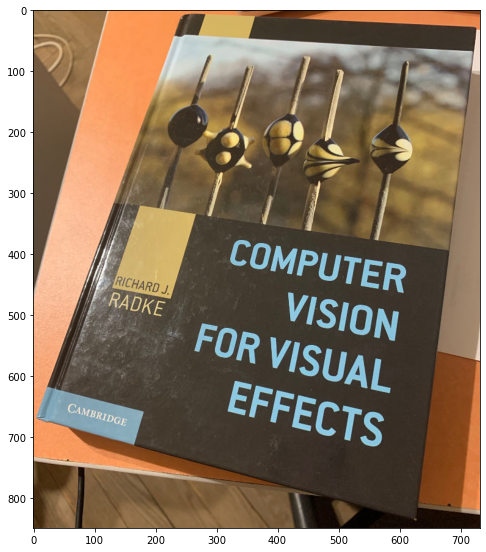

In [39]:
img_path = './res/cvbook.jpg'
img = read_img(img_path)
# img=img[:,:,0]
_plot(img)

And here we need to specify the transformation of 4 points(any 3 of them should not be collinear). Then we will be able to identify the transformation matrix for the entire image

In [40]:
original_points = np.float32([[241,6],[726,29],[6,668],[627,837]])

destination_size = (300, 400)
r,c = destination_size
transformed_points = np.float32([[0,0],[r,0],[0,c],[r,c]])

Below you can see which exactly points are inside `original_points` collection. If you take a look, we want to transform them to the bound of output image. In other words, we want a top-down view of the book captured on the original photo

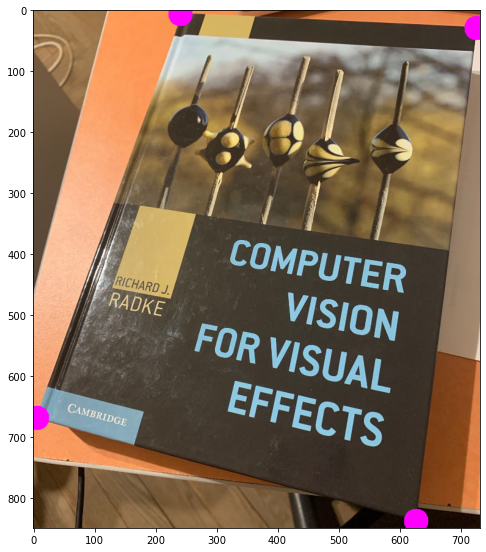

In [41]:
img_points = img.copy()
for p in original_points:
    cv2.circle(img_points, center=tuple(p), radius=20, color=(255,0,255), thickness=-1)

_plot(img_points)

## Our Implementation

While the idea of Affine transformation is restricted with 2D operations such as rotation, offset etc, Perspective transformation allow us get perform 3D operations. That is:
* we take a 2D picture
* map it to 3D space
* make any 3D space transformation e.g. rotation with 360 degress of freedom
* map it back to 2D space

With this approach we could stricly describe far more transformation e.g. when we want to map object on images taken from different angles or positions. You can find a great explanation of algorithm detail [here](https://math.stackexchange.com/questions/296794/finding-the-transform-matrix-from-4-projected-points-with-javascript). 

But implementation-wise, here we also want to find transformation matrix M. But in this case it won't be $[2 \cdot 3]$, as in Affine transformation, but $[3 \cdot 3]$, giving us 9 unknown parameters. Also, for each transformation there will be some specific scaling factor, giving us 1 more unknow per each transformation. Let us remind you, the we need to have 4 transformed points, which will provide us with 12 equations and 13 unknown values. Thus to find some specific tranformation, we will set $m_{3,3}=1$ of our transformation amtrix M. Below is implementation of it:

The function `get_coef` receives the original point `a`, the transformed result `b`, and ordinary number of example `n={0,1,2,3}` and returns a collection of 12-dimentional vectors, where each of them represents a single equation of our system with 12 unknown variables. You can check details of how this system is formulated [here](https://stackoverflow.com/questions/8925569/perspective-projection-4-points)

In [42]:
def get_coef(a, b, n):
    res = []
    b = [b[0], b[1], 1]
    dim = 3
    for i in range(dim):
        curr = [0] * dim * 4
        curr[i] = a[0]
        curr[dim + i] = a[1]
        curr[2*dim + i] = 1 if i != 2 else 0
        
        curr[3*dim + n - 1] = -b[i]
        res.append(curr)
        
    return res

In `getPerspectiveTransform` we get a 4 pairs of original points and their locations after transformation, and produce a $[3 \cdot 3]$ transformation matrix M, as was described above

In [43]:
def getPerspectiveTransform(pts1, pts2):
    A = []
    plen = len(pts1)
    for i in range(plen):
        A += get_coef(pts1[i], pts2[i], i)
        
    B = [0, 0, -1] * plen
    C = np.linalg.solve(A, B)
    # First 8 elements of C now contains a flattened transformation matrix M(the 9-th element is always set to 1)
    # while the last 4 elements are scaling factors specific for each example. Since we are only interested
    # in M, we will extract only its values below
    res = np.ones(9)
    res[:8] = C.flatten()[:8]
    return res.reshape(3,-1).T

We will use those auxiliary function to keep notations in algorithm consistent, i.e. when subsripting the `img[a,b]`, `a` will identify horizontal coordinates, while `b` - vertical. Currently OpenCV requires to pass point as parameter to any function in a form `(horizontal, vertical)`, while when accesses directly it should be `(vertical, horizontal)`.  
There is some overhead for changing the representation, but we accepted it in order to make our educative implementation more simple

In [44]:
def to_mtx(img):
    H,V,C = img.shape
#     H, V = img.shape
    mtr = np.zeros((V,H,C), dtype='int')
#     mtr = np.zeros((V,H), dtype='int')

    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
    
    return mtr

def to_img(mtr):
    V,H,C = mtr.shape
#     V,H = mtr.shape
    img = np.zeros((H,V,C), dtype='int')
#     img = np.zeros((H,V), dtype='int')
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]
        
    return img

With function `warpPerspective` we can construct the transformed image. That is, we pass original image as `img`, transformation matrix as `M`, and a size of transformed image as `dsize`. Again, as for affine transform, some pixels from original image might be mapped outside or into subwindow of the original image.

The biggest difference in `warpPerspective` copmparing to `warpAffine` is that after applying transformation M, we will get a point $p_3$ from 3D space, which we later need to project back to 2D space. That is:
$$p_3 = \begin{bmatrix} x' \\ y' \\ z' \end{bmatrix} = M \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

And to identify the projected point $p_2$ to the plane where z=1, we will need to divide each point coordinate by the 3-rd coordinate, that is 
$$p_2 = \begin{bmatrix} x'' \\ y'' \end{bmatrix} = \begin{bmatrix} \frac{x'}{z'} \\ \frac{y'}{z'} \end{bmatrix} $$

Also note, that for better visual results we should have also applied interpolation on resulting image but it is unimplemented at the moment

In [45]:
def warpPerspective(img, M, dsize):
    mtr = to_mtx(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
#     dst = np.zeros((R,C,mtr.shape[1]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            res = np.dot(M, [i,j,1])
            i2,j2,_ = (res / res[2] + 0.5).astype(int)
            if i2 >= 0 and i2 < R:
                if j2 >= 0 and j2 < C:
                    dst[i2,j2] = mtr[i,j]
    
    return to_img(dst)

In [46]:
%%time
M = getPerspectiveTransform(original_points, transformed_points)
print(M)

[[ 7.53496708e-01  2.67479949e-01 -1.83197586e+02]
 [-3.99227991e-02  8.41850329e-01  4.57029261e+00]
 [ 3.03922821e-04  6.21097907e-04  1.00000000e+00]]
Wall time: 1.01 ms


Wall time: 9.41 s


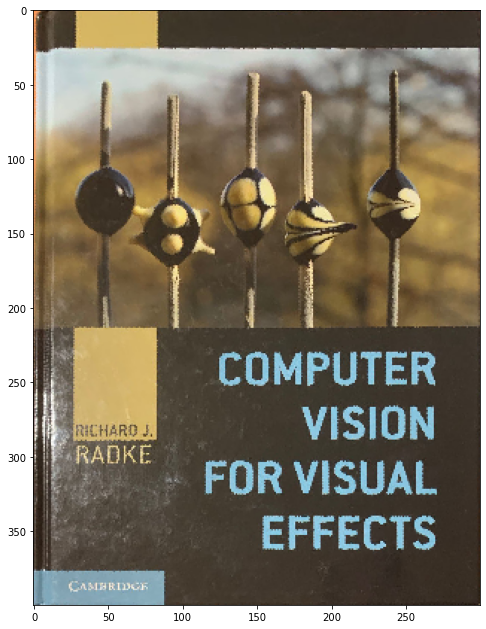

In [48]:
%%time
dst = warpPerspective(img, M, destination_size)
_plot(dst)

### OpenCV implementation

And in order to validate our implementation, we check results from OpenCV realization of [getPerspectiveTransform](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getaffinetransform#getperspectivetransform) and [warpPerspective](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getaffinetransform#warpperspective) functions, which, as we can see, show identical results (except that results from cv2.warpPerspective are additionally interpolated)

In [49]:
%%time
M_cv = cv2.getPerspectiveTransform(original_points, transformed_points)
print(M_cv)

[[ 7.53496708e-01  2.67479949e-01 -1.83197586e+02]
 [-3.99227991e-02  8.41850329e-01  4.57029261e+00]
 [ 3.03922821e-04  6.21097907e-04  1.00000000e+00]]
Wall time: 976 µs


Wall time: 26 ms


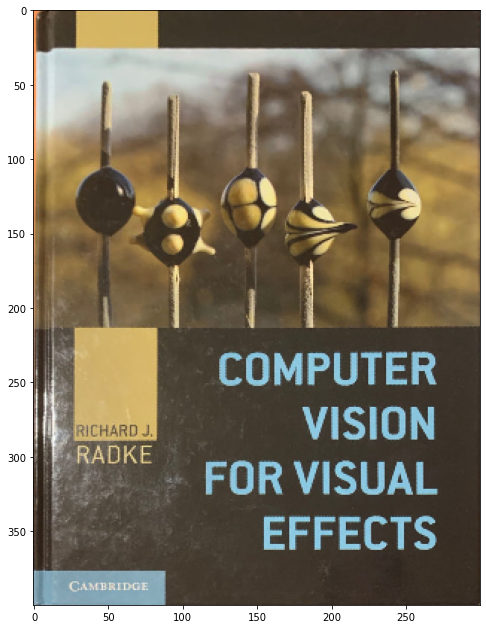

In [50]:
%%time
dst = cv2.warpPerspective(img, M_cv, destination_size)
_plot(dst)

In [51]:
print(img[:,:,0].shape)

(849, 732)
